# Событийная аналитика

Мы представляем стартап, который продает продукты питания. 

**Цель исследования** - определить модель поведения пользователей мобильного приложения.

**Задачи исследования**:
- на основе анализа воронки продаж проследить путь пользователей до покупки;
- рассчитать доли дошедших до покупки и "застрявших" на предыдущих шагах пользователей;
- оценить результаты  A/A/B-эксперимента.

О эксперименте: Дизайнеры предложили поменять шрифты во всём приложении, а менеджеры посчитали, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше. Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, то мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента мы работаем с одними и теми же данными, не учитывая принадлежность пользователей к экспериментам.

**Ход исследования**

Для анализа мы используем логи пользователей мобильного приложения - информацию о событиях и действиях пользователя в приложении с указанием времени и даты события, а также принадлежности пользователя к экспериментальной группе.

О качестве данных нам ничего неизвестно, поэтому перед проведением исследования понадобится обзор и предобработка данных: обработаем пропуски и дубликаты в случае наличия, приведем данные к необходимым типам, проведем дополнительные расчеты.

Затем мы проверим данные и оценим, какой объем данных имеется, какой период они покрывают, как представлены экспериментальные группы.

Потом изучим воронку событий - какие события в нее входят и в какой последовательности, каковы доли "отсвва" по этапам и в финале

После этого - проанализируем результаты A/A/B-теста: есть ли значимые различия между контрольными и экспериментальной группой.

Таким образом, решение пройдет в пять этапов.

## Обзор данных

Составим представление о данных. Импортируем специальную библиотеку pandas для обработки и анализа данных, а также другие библиотеки. 

In [1]:
import pandas as pd # импорт библиотеки pandas
import datetime as dt  # импорт библиотеки datetime для работы со временем
import matplotlib.pyplot as plt # импорт части библиотеки matplotlib для работы с диаграммами
import seaborn as sns # импорт библиотеки seaborn для работы с диаграммами
from plotly import graph_objects as go # импортируем набор методов для работы с интерактивными графиками
import numpy as np # импорт библиотеки numpy для математических вычислений
import math # импорт библиотеки math для математических вычислений
from scipy import stats as stats # импорт модуля stats для статистических методов

Прочитаем файл `/datasets/logs_exp.csv`, сохраним в переменную logs, а также выведем на экран начало таблицы.

In [2]:
# чтение файла с данными и сохранение в logs
try:
    # адрес в среде 'practicum'
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')  
except:
    # адрес в локальном окружении
    logs = pd.read_csv('logs_exp.csv', sep='\t')
# получение первых 5 строк таблицы
display(logs.head(5)) 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Получим общую информацию о таблице. 

In [3]:
logs.info() # получение общей информации о данных в таблице logs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Таблица `logs` (результаты эксперимента)
Каждая запись в логе - это действие или событие.

В таблице 4 столбца. Согласно документации к данным:
* `EventName` — название события, тип данных object;

Представлены следующие события:
   1. MainScreenAppear - показ главного экрана;
   2. OffersScreenAppear - показ экрана с предложением о покупке;        
   3. CartScreenAppear - показ корзины ;            
   4. PaymentScreenSuccessful - показ экрану успешной оплаты;    
   5. Tutorial - открытие обучения пользования приложением.

У остальных столбцов тип данных - int64: 
* `DeviceIDHash` — уникальный идентификатор устройства;
* `EventTimestamp` — время события;
* `ExpId` — — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная..

В таблице 244 126 значений в каждом столбце, скорее всего пропущенных значений нет.
Названия всех столбцов необходимо привести к хорошему стилю. Столбец `EventTimestamp` необходимо будет преобразовать в формат дата/время.

**Выводы**

Данные для анализа содержатся в таблице logs, они включают информацию о событиях пользователей и их принадлежности к группам в эксперименте. Для достижения целей исследования необходимо будет провести предобработку: привести данные к необходимым форматам, привести названия столбцов к хорошему стилю и убедиться в качестве данных. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

Обработаем названия столбцов, исключим пропуски данных и дубликаты, проверим данные на наличие аномалий и при необходимости избавимся от них. Приведем данные к необходимым типам.

### Приведение названий столбцов к хорошему стилю

Заменим названия столбцов в таблице logs - приведем к snake_case - нижний регистр с нижними поджчеркиваниями.

In [4]:
# Переименование столбца
logs.columns = ['event_name','device_id_hash', 'event_timestamp', 'exp_id']
# Проверка - вывод названий столбцов
logs.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

Теперь названия столбцов в порядке. 

### Расчет дополнительных показателей

Добавим столцбцы с данными в нужных типах. На основе столбца `event_timestamp` создадим столбцы с информацией о дате и дате-времени события.

In [5]:
# Изменение типа данных с помощью метода .to_datetime()
# даты представлены в unix-формате, поэтому используем аргумент unit='s' - измерение времени в секундах
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
# Запрос получившегося типа данных
print(type(logs['event_datetime'].dtype))
# Проверка - получение первых 5 строк таблицы
logs.head()

<class 'numpy.dtype[datetime64]'>


,event_name,device_id_hash,event_timestamp,exp_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Замена произведена успешно.

Выделим в отдельный столбец информацию о дате события.

In [6]:
# Выделение даты с помощью индекса .dt.date 
logs['event_date'] = logs['event_datetime'].dt.date 
# Запрос получившегося типа данных
print(type(logs['event_date'].dtype))
# Проверка - получение первых 5 строк таблицы
logs.head()

<class 'numpy.dtype[object_]'>


,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Тоже успешно. Теперь, когда все столбцы имеют верный формат данных, проверим данные на аномалии.

### Проверка данных на аномалии и дубликаты

Определим, есть ли в таблице logs пропуски.

In [7]:
# Запрос количества пропущенных значений по столбцам.
logs.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
event_datetime     0
event_date         0
dtype: int64

В таблицe, как мы и предположили, отсутствуют пропуски.

Проверим поля event_name, exp_id на аномалии.

In [8]:
# Запрос значений поля
print(logs.event_name.value_counts())
print(logs.exp_id.value_counts())

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64
248    85747
246    80304
247    78075
Name: exp_id, dtype: int64


Аномалий в содержании полей event_name и exp_id нет.  

Проверим принадлежнность id пользователей группам A и B.

In [9]:
# Создание списка user_id пользователей групп 246, 247 и 248
raw_id_list_246 = logs.query("exp_id == 246")['device_id_hash'].unique()
raw_id_list_247 = logs.query("exp_id == 247")['device_id_hash'].unique()
raw_id_list_248 = logs.query("exp_id == 248")['device_id_hash'].unique()

# Создание списка пользователей, входящих в два списка 
common_list_1 = set(raw_id_list_246).intersection(raw_id_list_247)
common_list_2 = set(raw_id_list_246).intersection(raw_id_list_248)
common_list_3 = set(raw_id_list_247).intersection(raw_id_list_248)


print ('Всего пользователей в группе 246 - ', len(raw_id_list_246))
print ('Всего пользователей в группе 247 - ', len(raw_id_list_247))
print ('Всего пользователей в группе 248 - ', len(raw_id_list_248))
print ('Всего пользователей, входящих в несколько списков - ', 
       len(common_list_1)+len(common_list_2)+len(common_list_3))


Всего пользователей в группе 246 -  2489
Всего пользователей в группе 247 -  2520
Всего пользователей в группе 248 -  2542
Всего пользователей, входящих в несколько списков -  0


Пользователи успешно разделены по группам. 

Теперь проверим таблицу на явные дубликаты.

In [10]:
# Запрос количества явных дубликатов
logs.duplicated().sum()

413

В таблице 413 дубликатов, избавимся от них. 

In [11]:
# удаление явных дубликатов (с удалением старых индексов и формированием новых)
logs = logs.drop_duplicates().reset_index(drop=True) 
logs.duplicated().sum() # проверка на отсутствие дубликатов

0

Теперь явных дубликатов в таблице нет. 
Мы проверили данные на аномалии и дубликаты, устранили небольшие погрешности и теперь можем приступать к дальнейшему анализу

## Общий анализ и проверка данных

Провелем первичный анализ данных: оценим общее количество событий и пользователей, период эксперимента и при необходимости отбросим неполные данные.

### Общая информация о пользователях и событиях

Рассчитаем, сколько всего событий в логе.

In [12]:
print('Всего событий в логе - ', logs.event_name.count())
print('По видам они распределены следующим образом:')
print(logs.event_name.value_counts())

Всего событий в логе -  243713
По видам они распределены следующим образом:
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


Рассчитаем количество пользователей в логе.

In [13]:
print ('Всего пользователей в логе -', logs.device_id_hash.nunique())
print('По экспериментальным группам они распределены следующим образом:')
print ('Группа 246 - ', len(raw_id_list_246))
print ('Группа 247 - ', len(raw_id_list_247))
print ('Группа 248 - ', len(raw_id_list_248))

Всего пользователей в логе - 7551
По экспериментальным группам они распределены следующим образом:
Группа 246 -  2489
Группа 247 -  2520
Группа 248 -  2542


Определим среднее количество событий на пользователя.

In [14]:
print ('Среднее количество событий на пользователя -', 
       round(logs.event_name.count() / logs.device_id_hash.nunique()))

Среднее количество событий на пользователя - 32


Пользователи достаточно активны. В среднем на пользователя приходится 32 события.

### Определение периода эксперимента

Определим, данными за какой период мы распологаем. Для этого найдем минимальную и максимальную дату событий.

In [15]:
print(f'Минимальная дата событий - {logs.event_date.min():%d.%m.%Y}')
print(f'Максимальная дата событий - {logs.event_date.max():%d.%m.%Y}')

Минимальная дата событий - 25.07.2019
Максимальная дата событий - 07.08.2019


У нас есть информация по событиям от 25 июля до 7 августа 2019 года, однако мы не можем быть уверены, что эти данные полные. Технически в логи пользователей могут "доезжать" события из прошлого и это может "перекашивать" данные. Проверим объем данных по датам.

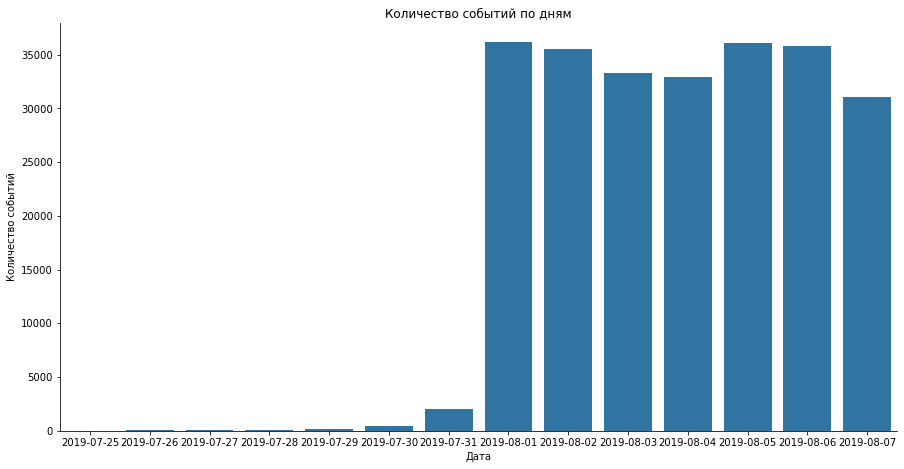

In [16]:
# Определение размера графика
plt.figure(
    figsize=(15, 7.5)
)  
# Построение диаграммы с распределением событий по датам
ax = sns.countplot(
    x='event_date', 
    data=logs,
    color='#1F77B4',
)
sns.despine()
# Добавление подписей графика и осей
plt.title('Количество событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
# Демонстрация графика
plt.show()

Действительно, в таблице есть нерелевантные данные - достаточный объем получен начиная с 1 августа, эксперимент продолжался неделю. Именно с 1 августа мы имеем одинаково полные данные. Теперь мы можем отбросить более старые. 

In [17]:
# Установление даты начала эксперимента
start_date = dt.datetime.strptime('2019-08-01', '%Y-%m-%d')
# Удаление более старых событий
logs_filtered = logs.loc[logs['event_datetime'] >= start_date]
# Проверка - запрос количества строк в таблице
print('Количество событий после удаления старых данных - ', len(logs_filtered))

Количество событий после удаления старых данных -  240887


Мы удалили старые данные. На самом деле мы располагаем данными с 1 по 7 августа 2019 года, и теперь наши данные соответствуют условиям эксперимента. 

### Оценка удаленных данных

Убедимся, что отбрасывая старые данные мы не потеряли слишком много событий и пользователей. 

In [18]:
print('Всего событий в логе - ', logs_filtered.event_name.count())
print(f'Было удалено событий - {logs.event_name.count() - logs_filtered.event_name.count()} \
или {(logs.event_name.count() - logs_filtered.event_name.count() )/ logs.event_name.count() :.3f} \
от всех событий.')

Всего событий в логе -  240887
Было удалено событий - 2826 или 0.012 от всех событий.


В результате мы отбросили 1.2% событий. Объем невелик и не повлияет на результаты эксперимента. 

Убедимся, что на структуру групп пользователей удаление старых данных так же не повлияло.

In [19]:
# Создание списка user_id пользователей групп 246, 247 и 248
id_list_246 = logs_filtered.query("exp_id == 246")['device_id_hash'].unique()
id_list_247 = logs_filtered.query("exp_id == 247")['device_id_hash'].unique()
id_list_248 = logs_filtered.query("exp_id == 248")['device_id_hash'].unique()


print (f'Всего пользователей в логе - {logs_filtered.device_id_hash.nunique()}, \
удалено - {logs.device_id_hash.nunique() - logs_filtered.device_id_hash.nunique()}.')
print('По экспериментальным группам они распределены следующим образом:')
print (f'Группа 246 - {len(id_list_246)}, удалено {len(raw_id_list_246) - len(id_list_246)}.')
print (f'Группа 247 - {len(id_list_247)}, удалено {len(raw_id_list_247) - len(id_list_247)}.')
print (f'Группа 248 - {len(id_list_248)}, удалено {len(raw_id_list_248) - len(id_list_248)}.')

Всего пользователей в логе - 7534, удалено - 17.
По экспериментальным группам они распределены следующим образом:
Группа 246 - 2484, удалено 5.
Группа 247 - 2513, удалено 7.
Группа 248 - 2537, удалено 5.


В результате мы удалили около 1% событий и 17 пользователей. Пользователи из групп удалены равномерно, что позволяет нам быть уверенными, что в эксперименте будут достаточно предсталены все группы.

**Вывод**
Мы подготовили данные: оценили общий объем данных - у нас есть информация о более, чем 7.5 тысячах пользователей, разделенных на три группы - 2 контрольные и одна экспериментальная, и свыше 240 000 событий. Период проведения эксперимента - с 1 по 7 августа.

## Анализ воронки событий

Изучим воронку событий. Охарактеризуем события, ее составляющие, установим цепочку этих событий, оценим динамику числа пользователей при проходе через воронку. 

### Виды событий

Посмотрим, какие события есть в логах и как часто они встречаются. Отсортируем события по частоте.

In [20]:
# Запрос частоты показателя
logs_filtered.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Чаще всего, что логично, встречается демонстрация главного экрана, за ним - демонстрация предложения, показ корзины, показ страницы успешной оплаты и прохождение обучения. Всего в логах около 240 000 событий, на демонстрацию главного экрана приходится около половины.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие.

In [21]:
# Сводная таблица с информацией о событиях и уникальных пользователях
event_users_pivot = logs_filtered.pivot_table(index = 'event_name', 
                 values = 'device_id_hash', 
                 aggfunc ='nunique',
                ).sort_values(by='device_id_hash', ascending=False)
total_users = logs.device_id_hash.nunique()
# Переименование столбца
event_users_pivot.columns = ['unique_users']
# Добавление столбца с информацией о доле пользователей
event_users_pivot['users_share'] = round(event_users_pivot.unique_users / total_users, 2)
# Демонстрация таблицы
display(event_users_pivot)

,unique_users,users_share
event_name,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.49
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


Порядок событий по числу уникальных пользователей сохранился. Наиболее распространенное событие - показ главного экрана, было у 99% пользователей, предложение о покупке рассматривали 61% пользователей, до демонстрации корзины дошли 50%, экран успешной оплаты продемонстрирован 47% пользователей, 11% прошли обучение.

### Построение воронки событий

События выстраиваются в следующую логическую цепочку:
1. Пользователю показан главный экран
2. Пользователю показан экран предложения о покупке
3. Пользователю показана корзина
4. Пользователю показан экран успешной оплаты.

Прохождение обучения не связано с остальными шагами и его не нужно учитываит при расчете воронки. Создадим таблицу с событиями, относящимися к воронке.

In [22]:
event_users_pivot.index

Index(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'],
      dtype='object', name='event_name')

In [23]:
# Построение воронки
funnel =  logs_filtered.pivot_table(
                                index='event_name',
                                values='device_id_hash',
                                aggfunc='nunique',
)
# Удаление лишних строк
funnel = funnel.loc[funnel.index != 'Tutorial']
# Сортировка данных
funnel = funnel.sort_values(by='device_id_hash', ascending=False)
# Переименование столбца
funnel.rename(columns = {'device_id_hash':'unique_users'}, inplace = True)
# Определение начального значения воронки
funnel_initial = funnel.loc['MainScreenAppear','unique_users']
# Рассчет доли от начального значения воронки
funnel['initial_share'] = round(funnel['unique_users'] / funnel_initial * 100, 2)
# Расчет доли от предылущего этапа
funnel['previous_share'] =  round(funnel['initial_share'] / funnel['initial_share'].shift() * 100, 2)
# Добавление названия события
funnel['event_title'] = ['Показ главной страницы', 
                        'Демонстрация предложения', 
                        'Начало оплаты', 
                        'Успешная покупка']
# Демонстрация таблицы
display(funnel)

,unique_users,initial_share,previous_share,event_title
event_name,,,,
MainScreenAppear,7419,100.00,NaN,Показ главной страницы
OffersScreenAppear,4593,61.91,61.91,Демонстрация предложения
CartScreenAppear,3734,50.33,81.30,Начало оплаты
PaymentScreenSuccessful,3539,47.70,94.77,Успешная покупка


Воронка готова. Теперь по ней посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Визуализируем воронку событий. 

In [33]:
# Построение диаграммы с помощью графических объектов библиотеки
fig = go.Figure(
    go.Funnel(
        y=funnel.event_title,
        x=funnel.unique_users,
    )
)
# Добавление назваания и выбор темы
fig.update_layout(
    title="Воронка событий мобильного приложения",
    template='simple_white', 
)
# Демонстрация диаграммы
fig.show() 

Больше всего пользователей теряется на первом шаге - при переходе от посещения главной страницы к демонстрации предложения. На этом этапе теряется 38% пользователей. 
От первого события до оплаты доходит 47,7% пользователей. 

**Вывод**

В воронку входят следующие события:
- показ главной страницы,
- демонстрация предложения,
- начало оплаты,
- успешная покупка.

Больше всего пользователей теряется на первом шаге - перед демонстрацией предложения. Всего до оплаты доходит почти 48% посетителей приложения.

## Анализ A/A/B-теста

Изучим результаты эксперимента. 
В ходе A/A/B-теста мы проверим следующие гипотезы:
* НО - нет значимых отличий в долях пользователей разных групп, имеющих в логах событие конкретного типа,
* Н1 - существуют значимые отличия в долях пользователей разных групп, имеющих в логах событие конкретного типа.

Мы проведем сравнения между контрольными группами, каждой из контрольных групп и экспериментальной, а также между обеими контрольными группами вместе и экспериментальной по всем событиям, входящим в воронку.

Для этого подготовим данные, функцию по определению разницы между выборками и проведем сравнение и проанализируем полученные результаты.

### Подготовка данных для анализа результатов  A/A/B-теста 

Подготовим сводную таблицу с информацией о количестве пользователей и событиях по группам.

In [25]:
# Сводная таблица по событиям и группам пользователей
test_table = logs_filtered.pivot_table(index='event_name',
                          columns = 'exp_id',
                          values = 'device_id_hash',
                          aggfunc='nunique')
# Удаление данных о не входящих в воронку событиях
test_table = test_table.loc[test_table.index != 'Tutorial']
# Добавление информации о двух контрольных группах вместе
test_table['246_247'] = test_table[246] + test_table[247]
# Добавим наименовани.я этапов вороник
test_table['event_title'] = funnel['event_title']
# Изменение индекса в соответствии с воронкой
test_table = test_table.reindex(funnel.index)
# Демонстрация таблицы
test_table

exp_id,246,247,248,246_247,event_title
event_name,,,,,
MainScreenAppear,2450,2476,2493,4926,Показ главной страницы
OffersScreenAppear,1542,1520,1531,3062,Демонстрация предложения
CartScreenAppear,1266,1238,1230,2504,Начало оплаты
PaymentScreenSuccessful,1200,1158,1181,2358,Успешная покупка


In [26]:
# Создание таблицы с информацией о пользователях по группам
users_table = logs_filtered.pivot_table(columns = 'exp_id',
                          values = 'device_id_hash',
                          aggfunc='nunique')
# Добавление информации о двух контрольных группах вместе
users_table['246_247'] = users_table[246] + users_table[247]
#
# Печать информации о количестве пользователей по группам
for col in users_table.columns:
    print ('Количество пользователей в группе', 
           users_table[col].name,'-', 
           *users_table[col].values, )
users_table

Количество пользователей в группе 246 - 2484
Количество пользователей в группе 247 - 2513
Количество пользователей в группе 248 - 2537
Количество пользователей в группе 246_247 - 4997


exp_id,246,247,248,246_247
device_id_hash,2484,2513,2537,4997


Теперь необходимо рассчитать доли от общего числа уникальных пользователей.

In [27]:
# Создание таблицы с информацией о долях пользователей в событиях
test_table_share = test_table / users_table.iloc[0]
# Добавим наименовани.я этапов вороник
test_table_share['event_title'] = funnel['event_title']
# Демонстрация таблицы
test_table_share

exp_id,246,247,248,246_247,event_title
event_name,,,,,
MainScreenAppear,0.986312,0.985277,0.982657,0.985791,Показ главной страницы
OffersScreenAppear,0.620773,0.604855,0.603469,0.612768,Демонстрация предложения
CartScreenAppear,0.509662,0.492638,0.484825,0.501101,Начало оплаты
PaymentScreenSuccessful,0.483092,0.460804,0.465510,0.471883,Успешная покупка


Теперь данные готовы к проведению анализа.

### Функция для проведения теста

Подготовим функцию для проведения статистического теста

In [28]:
def stat_test(data_table, users_table, event_name, sample_1, sample_2, 
              alpha = 0.01, event_title = 'event_title'):
    successes_1 = data_table.loc[event_name, sample_1]
    successes_2 = data_table.loc[event_name, sample_2]
    trials_1 = users_table[sample_1].iloc[0]
    trials_2 = users_table[sample_2].iloc[0]
    event_title = data_table[event_title].loc[event_name]
    # Пропорции успехов в первой и второй группе
    p1 = successes_1 / trials_1
    p2 = successes_2 / trials_2
    # Пропорции успехов в комбинированной группе
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2) 
    # Разница пропорций в датасетах
    difference = p1 - p2
    # Расчет статистики в стандартных отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt (p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2 ))
    # Создание стандартного нормального распределения (среднее - 0, стандартное отклонение - 1)
    distr = stats.norm (0, 1)
    # Расчет уровня вероятности
    p_value = (1 - distr.cdf(abs(z_value)))*2
    print(f'Сравнение групп {sample_1} и {sample_2}')
    print(
        f'Н0: Доли пользователей, имеющих событие \'{event_title}\', \
в группах {sample_1} и {sample_2} статистически значимо не различаются.')
    print(
        f'Н1: Доли пользователей, имеющих событие \'{event_title}\', \
в группах {sample_1} и {sample_2} имеют статистически значимые различия.')
    print((f'Уровень p-значения: {p_value:.3f}'))
    if p_value >= alpha:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
    else:
        print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
        print (f'Различие составляет {difference:.2%}')
    print('*****')

**Вывод**

Мы подготовили функцию, которая принимает 
- таблицу с данными пользовательской воронки,
- таблицу с информацией о числе уникальных пользователей в группе,
- идентификатор события, по которому будет проходить сравнение, 
- конкретные группы, которые будут сравниваться, 
- уровень значимости (значение по умолчанию - 0.01,
- название события, для вывода результатов.

Функция возвращает p-значение и результат проверки гипотезы. 

### Результаты  A/A-теста 

Используя подготовленную функцию, проверим, что существенных различий между контрольными группами нет и проведем A/A-тест. Контрольные группы в наших данных - под номерами 246 и 247.

In [29]:
# Сравнение групп по всем видам событий
for index in test_table.index:
    stat_test(test_table, users_table, index, 246, 247)

Сравнение групп 246 и 247
Н0: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 246 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 246 и 247 имеют статистически значимые различия.
Уровень p-значения: 0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 246 и 247
Н0: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 246 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 246 и 247 имеют статистически значимые различия.
Уровень p-значения: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 246 и 247
Н0: Доли пользователей, имеющих событие 'Начало оплаты', в группах 246 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Начало оплаты', в группах 246 и 247 имеют 

**Вывод:**
А/А тест проведен успешно. По его результатам обе группы продемонстрировали отсутствие отличие в долях по всем событиям. Это подтверждает корректность механизмов и наших расчетов.

### Результаты A/B теста.

Сравним экспериментальную группу (248) и первую из контрольных групп, группу 246.

In [30]:
# Сравнение групп по всем видам событий
for index in test_table.index:
    stat_test(test_table, users_table, index, 248, 246)

Сравнение групп 248 и 246
Н0: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 246 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 246 имеют статистически значимые различия.
Уровень p-значения: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 246
Н0: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 246 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 246 имеют статистически значимые различия.
Уровень p-значения: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 246
Н0: Доли пользователей, имеющих событие 'Начало оплаты', в группах 248 и 246 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Начало оплаты', в группах 248 и 246 имеют 

Значимых различий между группами пока обнаружить не удалось.

Сравним экспериментальную группу (248) со второй контрольной группой (247).

In [31]:
# Сравнение групп по всем видам событий
for index in test_table.index:
    stat_test(test_table, users_table, index, 248, 247)

Сравнение групп 248 и 247
Н0: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 247 имеют статистически значимые различия.
Уровень p-значения: 0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 247
Н0: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 247 имеют статистически значимые различия.
Уровень p-значения: 0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 247
Н0: Доли пользователей, имеющих событие 'Начало оплаты', в группах 248 и 247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Начало оплаты', в группах 248 и 247 имеют 

При сравнении со второй контрольной группой также не были обнаружены значимые различия.

Сравним экспериментальную группу (248) с двумя контрольными группами сразу (247_248).

In [32]:
# Сравнение групп по всем видам событий
for index in test_table.index:
    stat_test(test_table, users_table, index, 248, '246_247')

Сравнение групп 248 и 246_247
Н0: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 246_247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Показ главной страницы', в группах 248 и 246_247 имеют статистически значимые различия.
Уровень p-значения: 0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 246_247
Н0: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 246_247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Демонстрация предложения', в группах 248 и 246_247 имеют статистически значимые различия.
Уровень p-значения: 0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
*****
Сравнение групп 248 и 246_247
Н0: Доли пользователей, имеющих событие 'Начало оплаты', в группах 248 и 246_247 статистически значимо не различаются.
Н1: Доли пользователей, имеющих событие 'Начало опл

Сравнение с двумя контрольными группами сразу также не дало основание считать доли разными. 

**Вывод**

Эксперимент показал отсутствие значимых различий между контрольными и экспериментальной группой по всем событиям. Для эксперимента мы выбрали высокое значение уровня значимости, установив показатель альфа на 0.01. Будь он ниже мы могли бы признать часть различий значимыми.
Однако нами было проведено 16 тестов, что означает, что в 0.0625 случаев нами мог быть получен случайный результат. 

## Общий вывод

По результатам А/А/В-теста мы можем зафиксировать отсутствие различий между группами. 

Причина принятия этого решения следующая:
- на очищенных данных различия в конверсии между первой, второй, обеими вместе контрольными группами и экспериментальной группой не достигли уровня статистической значимости, это значит, что мы не можем отказаться от нулевой гипотезы - о том, что доли пользователей в этих руппах являются одинаковыми;
- предположение дизайнеров о смене шрифтов в приложении существенно не повлияло на путь пользователей.

По результатам теста можно предложить следующие рекомендации:
- обратить внимание на тот этап воронки, на котором происходит "отсев пользователей" - 38% пользователей не доходят с главной страницы приложения до просмотра специального предложения. Следует проверить приложение на отсутствие технических ошибок на этом этапе, продумать способы изменения пути пользователей в этом направлении. 
- рассмотреть возможность использования более простых механик экспериментов в дальнейшем - большое количество сравнений приводит к повышению уровню значимости статистических тестов, а это означает, что улавливаются только самые сильные различия, и чаще всего тест удорожается.